# plots for validations with Emma (for 10/3/22 meeting)


In [1]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_gwas_coloc")

source("script/functions.R"  )


In [2]:
outfolder = paste("manuscript_eqtl", "meeting_2022_03_10", sep = "/")
dir.create(outfolder, showWarnings = FALSE)


In [3]:
suppressPackageStartupMessages(library(stringr   ))
suppressPackageStartupMessages(library(colorspace))
suppressPackageStartupMessages(library(kohonen   ))
suppressPackageStartupMessages(library(tempR     ))
suppressPackageStartupMessages(library(latticeExtra))
suppressPackageStartupMessages(library(tis))


# Input data

In [4]:
exons = fread("/frazer01/reference/private/Gencode.v34lift37/exon_info.txt", sep = "\t", header = TRUE, data.table = FALSE)


In [5]:
exp_data = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/input/expdata_qtl.rds")
qtl_data = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/input/qtl/qtls.RDS"   )


In [6]:
coordinates = exp_data[["coordinates"]]
gene_info   = coordinates[ coordinates$phenotype == "rna",]


In [7]:
colordata_tissue = exp_data[["color"]][["by_tissue"]]
colordata_organ  = exp_data[["color"]][["by_organ" ]]
colordata_cell   = exp_data[["color"]][["by_cell"  ]]

colordata_tissue = colordata_tissue[colordata_tissue$body_site != "ipsc_cvpc",]
colordata_stage  = colordata_organ [c("ipsc_cvpc", "adult"),]
colordata_organ  = colordata_organ [c("arteria"  , "heart"),]

colordata_stage $order = 1:2
colordata_organ $order = 1:2
colordata_tissue$order = 1:nrow(colordata_tissue)

rownames(colordata_cell) = colordata_cell$cell_type
colordata_cell           = colordata_cell[,c("cell_type", "name", "color", "order")] 

mycols                    = c("body_site", "name", "color", "order")
colnames(colordata_stage ) = mycols
colnames(colordata_organ ) = mycols
colnames(colordata_tissue) = mycols
colnames(colordata_cell  ) = mycols

colordata_stage $type = "stage"
colordata_organ $type = "organ"
colordata_tissue$type = "tissue"
colordata_cell  $type = "cell"

colordata = list(by_stage = colordata_stage, by_organ = colordata_organ, by_tissue = colordata_tissue, by_cell = colordata_cell)

In [8]:
colordata_df = as.data.frame(rbindlist(colordata))

In [9]:
qtl2cell_list = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/pipeline/cell_type_associations/qtl2cell.rds")

In [10]:
for(x in names(qtl2cell_list))
{
    qtl2cell_list[[x]][,"by_tissue:ipsc_cvpc"] = NULL
    
    colnames(qtl2cell_list[[x]]) = gsub("by_organ:adult", "by_stage:adult", gsub("by_organ:ipsc_cvpc", "by_stage:ipsc_cvpc", colnames(qtl2cell_list[[x]])))
}

In [11]:
coloc    =              fread("pipeline/eqtls.0.1.coloc_gwas/coloc.txt"           , sep = "\t", header = TRUE, data.table = FALSE)
enr1     =              fread("pipeline/eqtls.0.1.coloc_gwas/enrichment_by_pp.txt", sep = "\t", header = TRUE, data.table = FALSE)
manifest = add_rownames(fread("pipeline/eqtls.0.1.coloc_gwas/manifest.txt"        , sep = "\t", header = TRUE, data.table = FALSE))
pph4     = coloc[ coloc$PP.H4.abf >= 0.8,]


In [12]:
coloc2cell = colSums(pph4[,grepl("^interaction", colnames(pph4))])
coloc2cell = data.frame(cell = sub("^interaction\\.", "", names(coloc2cell)), n = as.numeric(coloc2cell))


In [13]:
fm_list_old   = readRDS("pipeline/eqtl.4.finemap_single/fm_list.rds"  )

In [14]:
convert_colordata = function(colordata)
{
    colordata$by_organ $order  = colordata$by_organ $order + 0.5 + max(colordata$by_stage $order)
    colordata$by_tissue$order  = colordata$by_tissue$order + 0.5 + max(colordata$by_organ $order)
    colordata$by_cell  $order  = colordata$by_cell  $order + 0.5 + max(colordata$by_tissue$order)
    
    colordata$by_stage $pch = 21
    colordata$by_organ $pch = 23
    colordata$by_tissue$pch = 24
    colordata$by_cell  $pch = 22
    
    toplot = rbind(colordata[["by_stage" ]][,c("body_site", "name", "color", "order", "pch")],
                   colordata[["by_organ" ]][,c("body_site", "name", "color", "order", "pch")],
                   colordata[["by_tissue"]][,c("body_site", "name", "color", "order", "pch")],
                   colordata[["by_cell"  ]][,c("body_site", "name", "color", "order", "pch")]
                  )
    
    return(toplot)
}

locus2context = convert_colordata(colordata)

locus2context$n = unlist(lapply(rownames(locus2context), function(x)
{
    length(unique(pph4[ pph4[,paste("interaction", x, sep = ".")] == 1, "transcript_id"]))
}))


# Colocs to plot

In [15]:
myvars               = fread("/frazer01/home/matteo/documents/written/Cardips/cardiac_eqtls/for_validation/CM_Frazer_Variant_selection_20220126.txt", sep = "\t", header = TRUE, data.table = FALSE)
colnames(myvars)     = gsub(",", "", gsub("-", "", gsub("\\(", "", gsub(")", "", gsub(" ", "_", tolower(colnames(myvars)))))))
myvars$position      = as.numeric(gsub(",", "", myvars$position     ))
myvars$position_gwas = as.numeric(gsub(",", "", myvars$position_gwas))
myvars$type          = myvars$primary_or_conditional
myvars               = myvars[,c("gene_id", "transcript_id", "gene_name", "phenotype", "trait_id", "trait_name", "type", "snp_id", "rs_id", "chromosome", "position", "reference_allele", "alternative_allele", "overlaps_tss", "ppa_snp", "credible_set_size", "stage", "cell", "lead_snp_in_gwas_catalog", "position_gwas", "pvalue_gwas", "gwas_overlap_category")]

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


# plots

In [16]:
dir.create("pipeline/validation_plots", showWarnings = FALSE)

In [17]:
plot_celltype_binary = function(transcript_id, source, id, cell, colordata, legend = FALSE, panel = "")
{
    if(source == "tpm_gene"   ){phenotype = "rna"}
    if(source == "use_isoform"){phenotype = "isoform"}
    
    gtdata      = add_rownames(fread(paste("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/1.3.genotype"  , source, paste("gt_data", transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE))
    gtinfo      =              fread(paste("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/1.3.genotype"  , source, paste("gt_info", transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE)
    gtdata      = data.frame(wgs_id = colnames(gtdata), gt = as.numeric(gtdata[id,]))
    expdata     = exp_data[["expression"]][[phenotype]][["normalized"]][transcript_id,]
    expdata     = data.frame(run = colnames(expdata), norm = as.numeric(expdata[1,]))
    toplot      = merge(exp_data$covariates, exp_data$metadata[,c("run", "wgs_id", "phenotype")], by = "run")
    toplot      = toplot[toplot$phenotype == "rna",]
    toplot      = merge(toplot, expdata, by = "run")
    toplot      = merge(toplot, gtdata , by = "wgs_id"   )
    gtinfo      = gtinfo[gtinfo$id == id,]
    eqtls       = qtl_data[["qtl"]][[phenotype]]
    toplot$cell = toplot[,cell]
    toplot$x    = (toplot$gt * 4 + 1) + toplot$cell
    
    par(mar = c(2,4,3.5,1))
    #plot(1,1, type = "n", xlim = c(0,7), ylim = range(toplot$norm), axes = FALSE, xlab = "", ylab = "")
    plot(1,1, type = "n", xlim = c(0,7), ylim = c(-3,3), axes = FALSE, xlab = "", ylab = "")
    axis(2)
    
    mycolors = c("#bbbbbb", colordata[cell, "color"])
    
    boxplot(norm ~ cell + gt, data = toplot, outline = FALSE, col = rep(mycolors, 3), add = TRUE, at = (1:6), axes = FALSE)
    points (x = jitter(toplot$x, amount = 0.25), y = toplot$norm, pch = 16, cex = 0.5)
    abline (lm(norm ~ x, data = toplot[toplot$cell == 0,]), lty = "dashed", col = mycolors[[1]], lwd = 3)
    abline (lm(norm ~ x, data = toplot[toplot$cell == 1,]), lty = "dashed", col = mycolors[[2]], lwd = 3)
    
    gt1  = gtinfo[1, "ref" ]
    gt2  = gtinfo[1, "alt" ]
    rsid = gtinfo[1, "rsid"]
    gene = unique(eqtls[eqtls$transcript_id == transcript_id & eqtls$id == id, "gene_name"])
    gts  = c(paste(gt1, gt1, sep = "/"), paste(gt1, gt2, sep = "/"), paste(gt2, gt2, sep = "/"))
    
    if(source == "use_isoform"){gene = paste0(transcript_id, " (", gene, ")")}
    
    mtext(gts                    , side = 1, line =  0  , at = c(1.5, 3.5, 5.5))
    mtext(gene                   , side = 3, line =  2  , font = 3)
    mtext(rsid                   , side = 3, line =  0.5)
    mtext("Normalized expression", side = 2, line =  2.5)
    #mtext(text = panel           , side = 2, line =  2.5, las = 2, at = max(toplot$norm) * 1.05, font = 2, cex = 1.5)
    mtext(text = panel           , side = 2, line =  2.5, las = 2, at = 3 * 1.05, font = 2, cex = 1.5)
    
    if(legend == TRUE)
    {
        mylabs = c("All other samples", colordata[cell, "tissue"])
        
        if (cell == "ipsc_cvpc"      ){mylabs[[1]] = "Adult"         }
        if (cell == "heart_ventricle"){mylabs[[2]] = "Left ventricle"}
        
        myoffset = 0
        if(eqtls[eqtls$transcript_id == transcript_id & eqtls$id == id, "beta"] > 0){myoffset = 5}
        points(x = rep(0  , 2), y = c(-2.7, -2.3) + myoffset, pch = 22, bg = mycolors, cex = 2)
        text  (x = rep(0.1, 2), y = c(-2.7, -2.3) + myoffset, labels = mylabs, pos = 4, cex = 1.2)
    }
}

plot_celltype_quantile = function(transcript_id, source, id, cell, colordata, legend = FALSE, panel = "", quantiles = 4)
{
    if(source == "tpm_gene"){phenotype = "rna"}
    
    gtdata   = add_rownames(fread(paste("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/1.3.genotype"  , source, paste("gt_data", transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE))
    gtinfo   =              fread(paste("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/1.3.genotype"  , source, paste("gt_info", transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE)
    gtdata   = data.frame(wgs_id = colnames(gtdata), gt = as.numeric(gtdata[id,]))
    expdata  = exp_data[["expression"]][[phenotype]][["normalized"]][transcript_id,]
    expdata  = data.frame(run = colnames(expdata), norm = as.numeric(expdata[1,]))
    toplot   = merge(exp_data$covariates, exp_data$metadata[,c("run", "wgs_id", "phenotype")], by = "run")
    toplot   = toplot[toplot$phenotype == "rna",]
    toplot   = merge(toplot, expdata, by = "run")
    toplot   = merge(toplot, gtdata , by = "wgs_id"   )
    gtinfo   = gtinfo[gtinfo$id == id,]
    eqtls    = qtl_data[["qtl"]][[phenotype]]
    
    toplot$cell     = toplot[,cell]
    toplot          = toplot[order(toplot$cell),]
    quantiles       = round((1:quantiles) / quantiles * nrow(toplot), digits = 0)
    toplot$quantile = 0
    
    for(ii in 1:length(quantiles))
    {
        x1 = quantiles[[ii]]
        x0 = 1
        if (ii > 1){x0 = quantiles[[ii - 1]] + 1}
        
        toplot[x0:x1, "quantile"] = ii
    }
    
    toplot$gt_quantile     = paste(toplot$gt, toplot$quantile)
    tobox                  = aggregate(norm ~ quantile + gt + gt_quantile, data = toplot, mean)
    tobox                  = tobox[order(tobox$gt, tobox$quantile),]
    
    if(nrow(tobox) < 12)
    {
        tobox_left             = expand.grid(quantile = 1:4, gt = c(0, 0.5, 1))
        tobox_left$gt_quantile = paste(tobox_left$gt, tobox_left$quantile)
        tobox_left$norm        = 0
        tobox                  = rbind(tobox, tobox_left[!tobox_left$gt_quantile %in% tobox$gt_quantile,])
        tobox                  = tobox[ order(tobox$gt, tobox$quantile),]
    }

    tobox$x            = 1:nrow(tobox)
    toplot             = merge(toplot, tobox[,c("gt_quantile", "x")])
    quantile2color     = data.frame(quantile = sort(unique(toplot$quantile)), color = sequential_hcl(n = length(unique(toplot$quantile)), palette = "Sunset", rev = TRUE))
    
    par(mar = c(2,4,3.5,1))
    plot(1,1, type = "n", xlim = c(0,max(toplot$x + 1)), ylim = c(-3,3), axes = FALSE, xlab = "", ylab = "")
    axis(2)
    
    boxplot(norm ~ quantile + gt, data = toplot, outline = FALSE, col = rep(quantile2color$color, 3), add = TRUE, at = tobox$x, axes = FALSE)
    points (x = jitter(toplot$x, amount = 0.25), y = toplot$norm, pch = 16, cex = 0.5)
    
    invisible(lapply(1:nrow(quantile2color), function(ii)
    {
        this = toplot[toplot$quantile == quantile2color[ii, "quantile"],]
        
        abline (lm(norm ~ x, data = this), lty = "dashed", col = quantile2color[ii, "color"], lwd = 3)
    }))
    
    gt1       = gtinfo[1, "ref" ]
    gt2       = gtinfo[1, "alt" ]
    rsid      = gtinfo[1, "rsid"]
    this_eqtl = eqtls[eqtls$transcript_id == transcript_id & eqtls$id == id, ]
    gene      = unique(this_eqtl[, "gene_name"])
    gts       = c(paste(gt1, gt1, sep = "/"), paste(gt1, gt2, sep = "/"), paste(gt2, gt2, sep = "/"))
    
    mtext(gts                    , side = 1, line =  0  , at = aggregate(x ~ gt, data = tobox, FUN = mean)$x)
    mtext(gene                   , side = 3, line =  2  , font = 3)
    mtext(rsid                   , side = 3, line =  0.5)
    #mtext(cell                   , side = 3, line = -1  )
    mtext("Normalized expression", side = 2, line =  2.5)
    #mtext(text = panel           , side = 2, line =  2.5, las = 2, at = max(toplot$norm) * 1.05, font = 2, cex = 1.5)
    mtext(text = panel           , side = 2, line =  2.5, las = 2, at = 3 * 1.05, font = 2, cex = 1.5)

    if(legend == TRUE)
    {
        myoffset = 0
        if(eqtls[eqtls$transcript_id == transcript_id & eqtls$id == id, "beta"] < 0){myoffset = 5}
        points(x = rep(10  , nrow(quantile2color)), y = -((1:nrow(quantile2color)) / 3) - 1.5 + myoffset, pch = 22, bg = quantile2color$color, cex = 2)
        text  (x = rep(10.1, nrow(quantile2color)), y = -((1:nrow(quantile2color)) / 3) - 1.5 + myoffset, labels = paste("Quantile", quantile2color$quantile), pos = 4, cex = 1.2)
    }
}


change_color_points = function(x, lead, credible_set, mycol)
{
    x$color = "#000000"
    x$pch   = 21
    x$cex   =  1
    
    x[x$id %in% credible_set, "color"] = "#ff00ff"
    x[x$id %in% credible_set, "pch"  ] = 23
    x[x$id %in% credible_set, "cex"  ] =  2
    
    x[x$id == lead, "color"] = "#ff0000"
    x[x$id == lead, "cex"  ] = 2.5
    
    x = x[order(x$cex, x[,mycol], decreasing = FALSE),]
    
    return(x)
}

plot_pp = function(fm_list, transcript_id, type, trait, genes_to_exons, panels = rep("", 3))
{
    myname            = names(fm_list)[names(fm_list) %like% paste(transcript_id, type, trait, sep = ":")]
    indata            = fm_list[[ myname]]
    gwas              = indata$gwas
    gwas              = gwas[is.na(gwas$pval) == FALSE,]
    qtl               = indata$qtl
    finemap           = indata$finemap
    ids               = indata$credible_set
    id                = finemap[1,"id"]
    rsid              = qtl    [id, "rsid"]
    xlims             = range(finemap$pos)
    qtl $logp         = -log10(qtl $pval)
    gwas$logp         = -log10(gwas$pval)
    rownames(finemap) = finemap$id
    qtl               = change_color_points(qtl    , id, ids, "logp")
    gwas              = change_color_points(gwas   , id, ids, "logp")
    finemap           = change_color_points(finemap, id, ids, "pp"  )
        
    layout(cbind(c(1,1,2,2,3,3,4)))
    if(transcript_id == "ENSG00000274070.2_4"){xlims[[2]] = xlims[[2]] + 100000}
    
    par(mar = c(0.1,4.5, 0, 1))
    
    snp_pos = 4
    if(transcript_id %in% c("ENSG00000221963.6_4", "ENSG00000274070.2_4", "ENSG00000267280.5_8")){snp_pos = 2}
    
    # plot QTL signal
    plot(1,1, type = "n", xlim = xlims, ylim = c(0, max(qtl$logp)), xlab = "", ylab = "", axes = FALSE)
    axis(2)
    
    abline(h = 0)
    points(qtl$pos, qtl$logp, cex = qtl$cex, pch = qtl$pch, bg = qtl$color)
    abline(v = qtl[id, "pos"], lty = "dashed", col = "#ff0000")
    text  (    qtl[id, "pos"], qtl[id, "logp"], cex = 1.5, labels = rsid, pos = snp_pos)
    
    mtext(text = "-log10(p) eQTL", side = 2, line = 2.5)
    mtext(text = panels[[1]]     , side = 2, line = 2.5, las = 2, at = max(qtl$logp), cex = 1.5, font = 2)
    
    if(nrow(gwas[ is.infinite(gwas$logp) == TRUE, ]) > 0){gwas[ is.infinite(gwas$logp) == TRUE, "logp"] = max(gwas[ is.infinite(gwas$logp) == FALSE, "logp"])}
    
    # plot GWAS signal
    plot(1,1, type = "n", xlim = xlims, ylim = c(0, max(gwas$logp)), xlab = "", ylab = "", axes = FALSE)
    axis(2)
    
    abline(h = 0)
    points(gwas$pos, gwas$logp, cex = gwas$cex, pch = gwas$pch, bg = gwas$color)
    text  (    gwas[id, "pos"], gwas[id, "logp"], cex = 1.5, labels = rsid, pos = snp_pos)
    abline(v = gwas[id, "pos"], lty = "dashed", col = "#ff0000")
    
    mtext(text = "-log10(p) GWAS", side = 2, line = 2.5)
    mtext(text = panels[[2]]     , side = 2, line = 2.5, las = 2, at = max(gwas$logp), cex = 1.5, font = 2)
    
    # plot PP
    pp = finemap

    plot(1,1, type = "n", xlim = xlims, ylim = c(0, 1), xlab = "", ylab = "", axes = FALSE)
    axis(2)
    
    abline(h = 0)
    points(pp$pos, pp$pp, cex = pp$cex, pch = pp$pch, bg = pp$color)
    text  (    pp[id, "pos"], pp[id, "pp"], cex = 1.5, labels = rsid, pos = snp_pos)
    abline(v = pp[id, "pos"], lty = "dashed", col = "#ff0000")
    
    mtext(text = "PPA"      , side = 2, line = 2.5)
    mtext(text = panels[[3]], side = 2, line = 2.5, las = 2, at = 1, cex = 1.5, font = 2)
    
    # plot exons
    genes_plot   = coordinates[ coordinates$gene_name %in% genes_to_exons & coordinates$phenotype == "rna",]
    exons_plot   = exons      [ exons      $gene_name %in% genes_to_exons,]
    genes_plot   = genes_plot[order(genes_plot$start),]
    genes_plot$y = 1:nrow(genes_plot)
    
    par(mar = c(4.5, 4.5, 0, 1))
    plot(1,1, type = "n", xlim = xlims, ylim = c(nrow(genes_plot),0), xlab = "", ylab = "", axes = FALSE)
    
    axis(1, at = pretty(xlims), labels = pretty(xlims) * 1e-6)
    
    for(gene in genes_plot$gene_name)
    {
        
        y0      = genes_plot[ genes_plot$gene_name == gene, "y"]
        exons_x = exons_plot[ exons_plot$gene_name == gene, ]
        mypos   = 4
        myx     = max(exons_x$end)
        
        if(gene %in% c("HMGB1", "CASTOR2", "APOL6", "TBX2-AS1", "WFIKKN1", "RAB40C")){mypos = 2}
        if(gene %in% c("HMGB1", "CASTOR2", "APOL6", "TBX2-AS1", "WFIKKN1", "RAB40C")){myx   = min(exons_x$start)}
        
        rect(xleft = exons_x$start, xright = exons_x$end, ybottom = y0 - 0.1, ytop = y0 - 0.9, col = "#2E8B57", border = "#2E8B57")
        segments(x0 = min(exons_x$start), x1 = max(exons_x$end), y0 = y0 - 0.5, col = "#2E8B57", lwd = 2)
        text(x = myx, y = 0.5, labels = gene, cex = 1.5, col = "#2E8B57", font = 3, pos = mypos)
        
        if(gene == "PRKG1"){text(x = 53.72e6, y = 0.5, labels = gene, cex = 1.5, col = "#2E8B57", font = 3, pos = 3)}
    }

    abline(v = pp[id, "pos"], lty = "dashed", col = "#ff0000")
    
    #mtext(text = paste0("chr", unlist(strsplit(locus, "_"))[[1]], " (Mb)"), side = 1, line = 2.5)
}



plot_gene = function(ii, myvars, size_x = 8.5, size_y = 11,to_png = FALSE)
{
    gene_id       = myvars[ii, "gene_id"      ]
    gene_name     = myvars[ii, "gene_name"    ]
    transcript_id = myvars[ii, "transcript_id"]
    snp_id        = myvars[ii, "snp_id"       ]
    type          = myvars[ii, "type"         ]
    trait_id      = myvars[ii, "trait_id"     ]
    
    message(gene_id, appendLF = FALSE)
    
    
    #if(to_png == TRUE ){png(filename = paste("pipeline/validation_plots", paste(gene_id, type, "png", sep = "."), sep = "/"), width = size_x, height = size_y, units = "in", res = 300)}
    #if(to_png == FALSE){options(repr.plot.width = size_x, repr.plot.height = size_y)}

    #plot_celltype_binary  (transcript_id, "tpm_gene", snp_id , "ipsc_cvpc"                       , add_rownames(exp_data$color$by_tissue), TRUE, "A")
    #plot_celltype_quantile(transcript_id, "tpm_gene", snp_id , "cibersort.regular.cardiac_muscle", add_rownames(exp_data$color$by_tissue), TRUE, "A")
    
    #return(list(transcript_id, type, trait_id, snp_id, gene_name))
    png(filename = paste("pipeline/validation_plots", paste(gene_name, type, "png", sep = "."), sep = "/"), width = size_x, height = size_y, units = "in", res = 300)
    
    plot_pp(fm_list_old, transcript_id, type, trait_id, gene_name, c("", "", ""))
    dev.off()
    #if(to_png == TRUE){dev.off()}
}

ii = 1
invisible(lapply(1:nrow(myvars), function(ii){plot_gene(ii, myvars, size_x = 8.5, size_y = 11,to_png = TRUE)}))
#dev.off()

ENSG00000164867.11_5
ENSG00000165097.16_6
ENSG00000198523.6_4
ENSG00000146674.15_9
ENSG00000152217.19_8
ENSG00000139899.11_5
ENSG00000272391.6_7
ENSG00000064989.13_5
ENSG00000165895.19_6
ENSG00000156603.19_7
ENSG00000187720.14_6
ENSG00000196821.10_8
ENSG00000262655.4_5
ENSG00000069188.17_6
ENSG00000077522.13_4
ENSG00000103995.14_8
ENSG00000182534.13_5
ENSG00000114450.10_6
ENSG00000153814.13_6
ENSG00000203546.7_8
ENSG00000119139.20_9
ENSG00000103479.16_5
ENSG00000166446.15_6
ENSG00000105974.12_6
ENSG00000117461.15_6


In [18]:
dev.off()

null device 
          1

In [19]:
str(fm_list_old[1:3])

List of 3
 $ ENSG00000000971.16_4:0:biomarkers-30600-both_sexes-irnt:1_196248779_197362184:List of 11
  ..$ transcript_id : chr "ENSG00000000971.16_4"
  ..$ phenotype     : chr "rna"
  ..$ type          : int 0
  ..$ locus         : chr "1_196248779_197362184"
  ..$ trait         : chr "biomarkers-30600-both_sexes-irnt"
  ..$ coord         : chr "1:196248779-197362184"
  ..$ gwas          :'data.frame':	2529 obs. of  5 variables:
  .. ..$ pos : int [1:2529] 196248826 196249082 196249394 196250413 196250589 196250988 196251522 196251694 196252118 196252159 ...
  .. ..$ id  : chr [1:2529] "VAR_1_196248826_G_A" "VAR_1_196249082_T_A" "VAR_1_196249394_G_C" "VAR_1_196250413_C_T" ...
  .. ..$ beta: num [1:2529] 0.01319 -0.00768 -0.03075 0.00587 -0.01241 ...
  .. ..$ se  : num [1:2529] 0.00276 0.0025 0.06342 0.0033 0.00498 ...
  .. ..$ pval: num [1:2529] 1.69e-06 2.14e-03 6.28e-01 7.58e-02 1.27e-02 ...
  ..$ qtl           :'data.frame':	1293 obs. of  11 variables:
  .. ..$ chrom     : int [1:1

In [21]:
#
#figure_5 = function(size_x = 12, size_y = 12,to_png = FALSE)
#{
#    if(to_png == TRUE ){png(filename = paste(outfolder, "Figure_5.png", sep = "/"), width = size_x, height = size_y, units = "in", res = 300)}
#    if(to_png == FALSE){options(repr.plot.width = size_x, repr.plot.height = size_y)}
#    
#    layout(cbind(c(sort(rep(1:4, 2)), 5), 
#                 c(sort(rep(1:4, 2)), 5), 
#                 sort(rep(6:8, 3)), 
#                 rep(9,9))
#          )
#    
#    plot_pp(fm_list_old, "ENSG00000054654.18_8", 0, "icd10-I48-both_sexes", "14_64512858_64914311" , c("SYNE2", "ESR2"), c("B", "C", "D"))
#    
#
#    if(to_png == TRUE ){dev.off()}
#}
#
#figure_5(to_png = FALSE)
#

# Find expression of specific genes

[1]  0.48 61.69

[1]  2.76 12.43

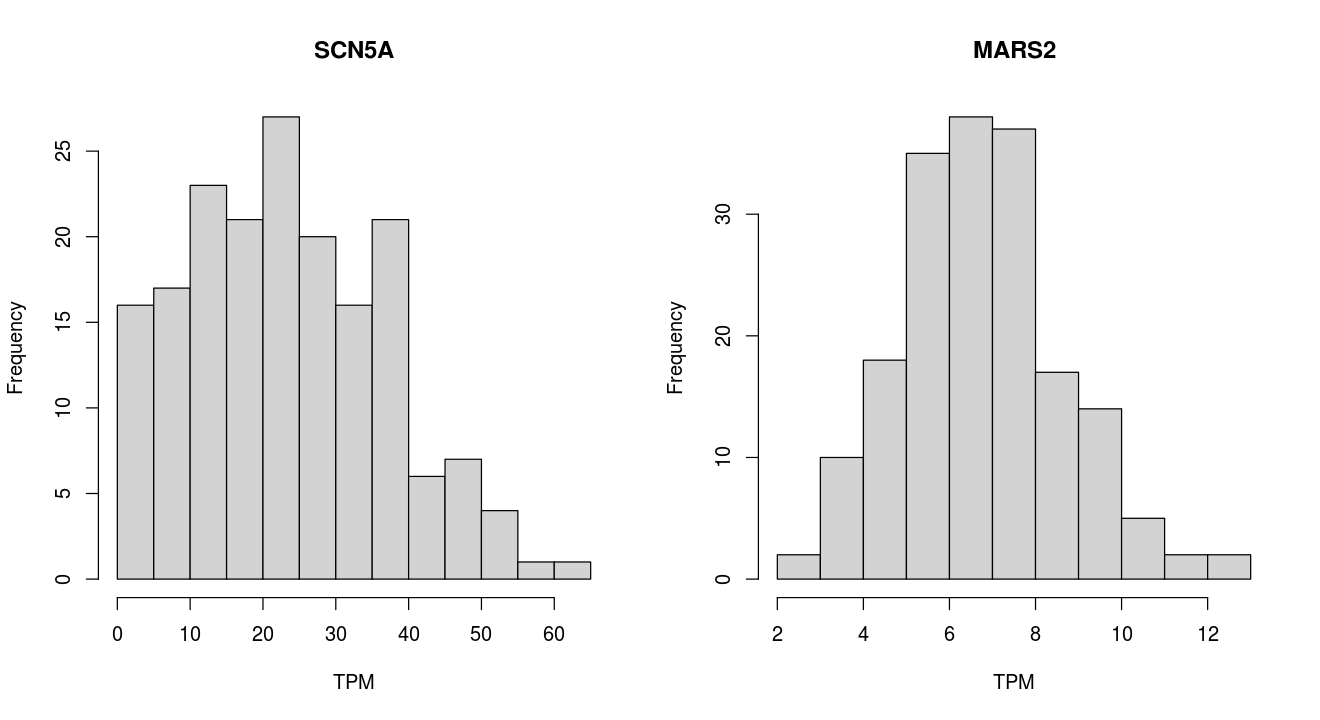

In [22]:
plot_expression = function(gene_name, tissue, exp_data)
{
    ids      = exp_data[["metadata"   ]]
    gene_ids = exp_data[["coordinates"]]
    expdata  = exp_data[["expression" ]][["rna"]][["expression"]]
    gene_id  = gene_ids[ gene_ids$gene_name == gene_name & gene_ids$phenotype == "rna", "gene_id"]
    ids      = ids[ ids$tissue == tissue & ids$phenotype == "rna", "run"]
    expdata  = as.numeric(expdata[ gene_id, ids])
    
    hist(expdata, main = gene_name, xlab = "TPM")
    
    return(range(expdata))
}

options(repr.plot.width = 11, repr.plot.height = 6)
layout(rbind(1:2))
plot_expression("SCN5A", "ipsc_cvpc", exp_data)
plot_expression("MARS2", "ipsc_cvpc", exp_data)


# plot boxes

In [47]:
totest       = fread("hg19-eqtl-ids-for-matteo.txt", sep = "\t", header = TRUE, data.table = FALSE)
totest$id    = paste("VAR", sub("chr", "", totest$chrom), totest$pos, totest$ref, totest$alt, sep = "_")
totest       = ddply(totest, .(id, chrom, pos1, ref, alt, hg38_snvid), function(DF) {data.frame(transcript_id = strsplit(DF$transcript_ids, ",")[[1]])})
totest$trait = ifelse(grepl("pulse_pressure", totest$hg38_snvid) == TRUE, yes = "continuous-PP-both_sexes-combined_medadj_irnt", no = "continuous-102-both_sexes-irnt")  


In [48]:
totest

id,chrom,pos1,ref,alt,hg38_snvid,transcript_id,trait
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
VAR_1_183592570_C_T,chr1,183592570,C,T,gwas_uk_pulse_pressure_chr1_183623435_C_T,ENSG00000162704.16_6,continuous-PP-both_sexes-combined_medadj_irnt
VAR_10_60276369_T_C,chr10,60276369,T,C,gwas_uk_pulse_pressure_chr10_58516609_T_C,ENSG00000122870.12_5,continuous-PP-both_sexes-combined_medadj_irnt
VAR_12_48607737_T_C,chr12,48607737,T,C,gwas_uk_pulse_pressure_chr12_48213954_T_C,ENSG00000177981.11_6,continuous-PP-both_sexes-combined_medadj_irnt
VAR_12_48607737_T_C,chr12,48607737,T,C,gwas_uk_pulse_pressure_chr12_48213954_T_C,ENSG00000240399.1_6,continuous-PP-both_sexes-combined_medadj_irnt
VAR_16_19880943_C_G,chr16,19880943,C,G,gwas_uk_pulse_rate_chr16_19869621_C_G,ENSG00000261312.1_9,continuous-102-both_sexes-irnt
VAR_16_19880943_C_G,chr16,19880943,C,G,gwas_uk_pulse_rate_chr16_19869621_C_G,ENSG00000103550.14_9,continuous-102-both_sexes-irnt
VAR_17_46203430_C_G,chr17,46203430,C,G,gwas_uk_pulse_pressure_chr17_48126068_C_G,ENSG00000108465.15_5,continuous-PP-both_sexes-combined_medadj_irnt
VAR_17_46203430_C_G,chr17,46203430,C,G,gwas_uk_pulse_pressure_chr17_48126068_C_G,ENSG00000108465.15_5,continuous-PP-both_sexes-combined_medadj_irnt
VAR_5_137314066_A_G,chr5,137314066,A,G,gwas_uk_pulse_rate_chr5_137978377_A_G,ENSG00000031003.10_5,continuous-102-both_sexes-irnt


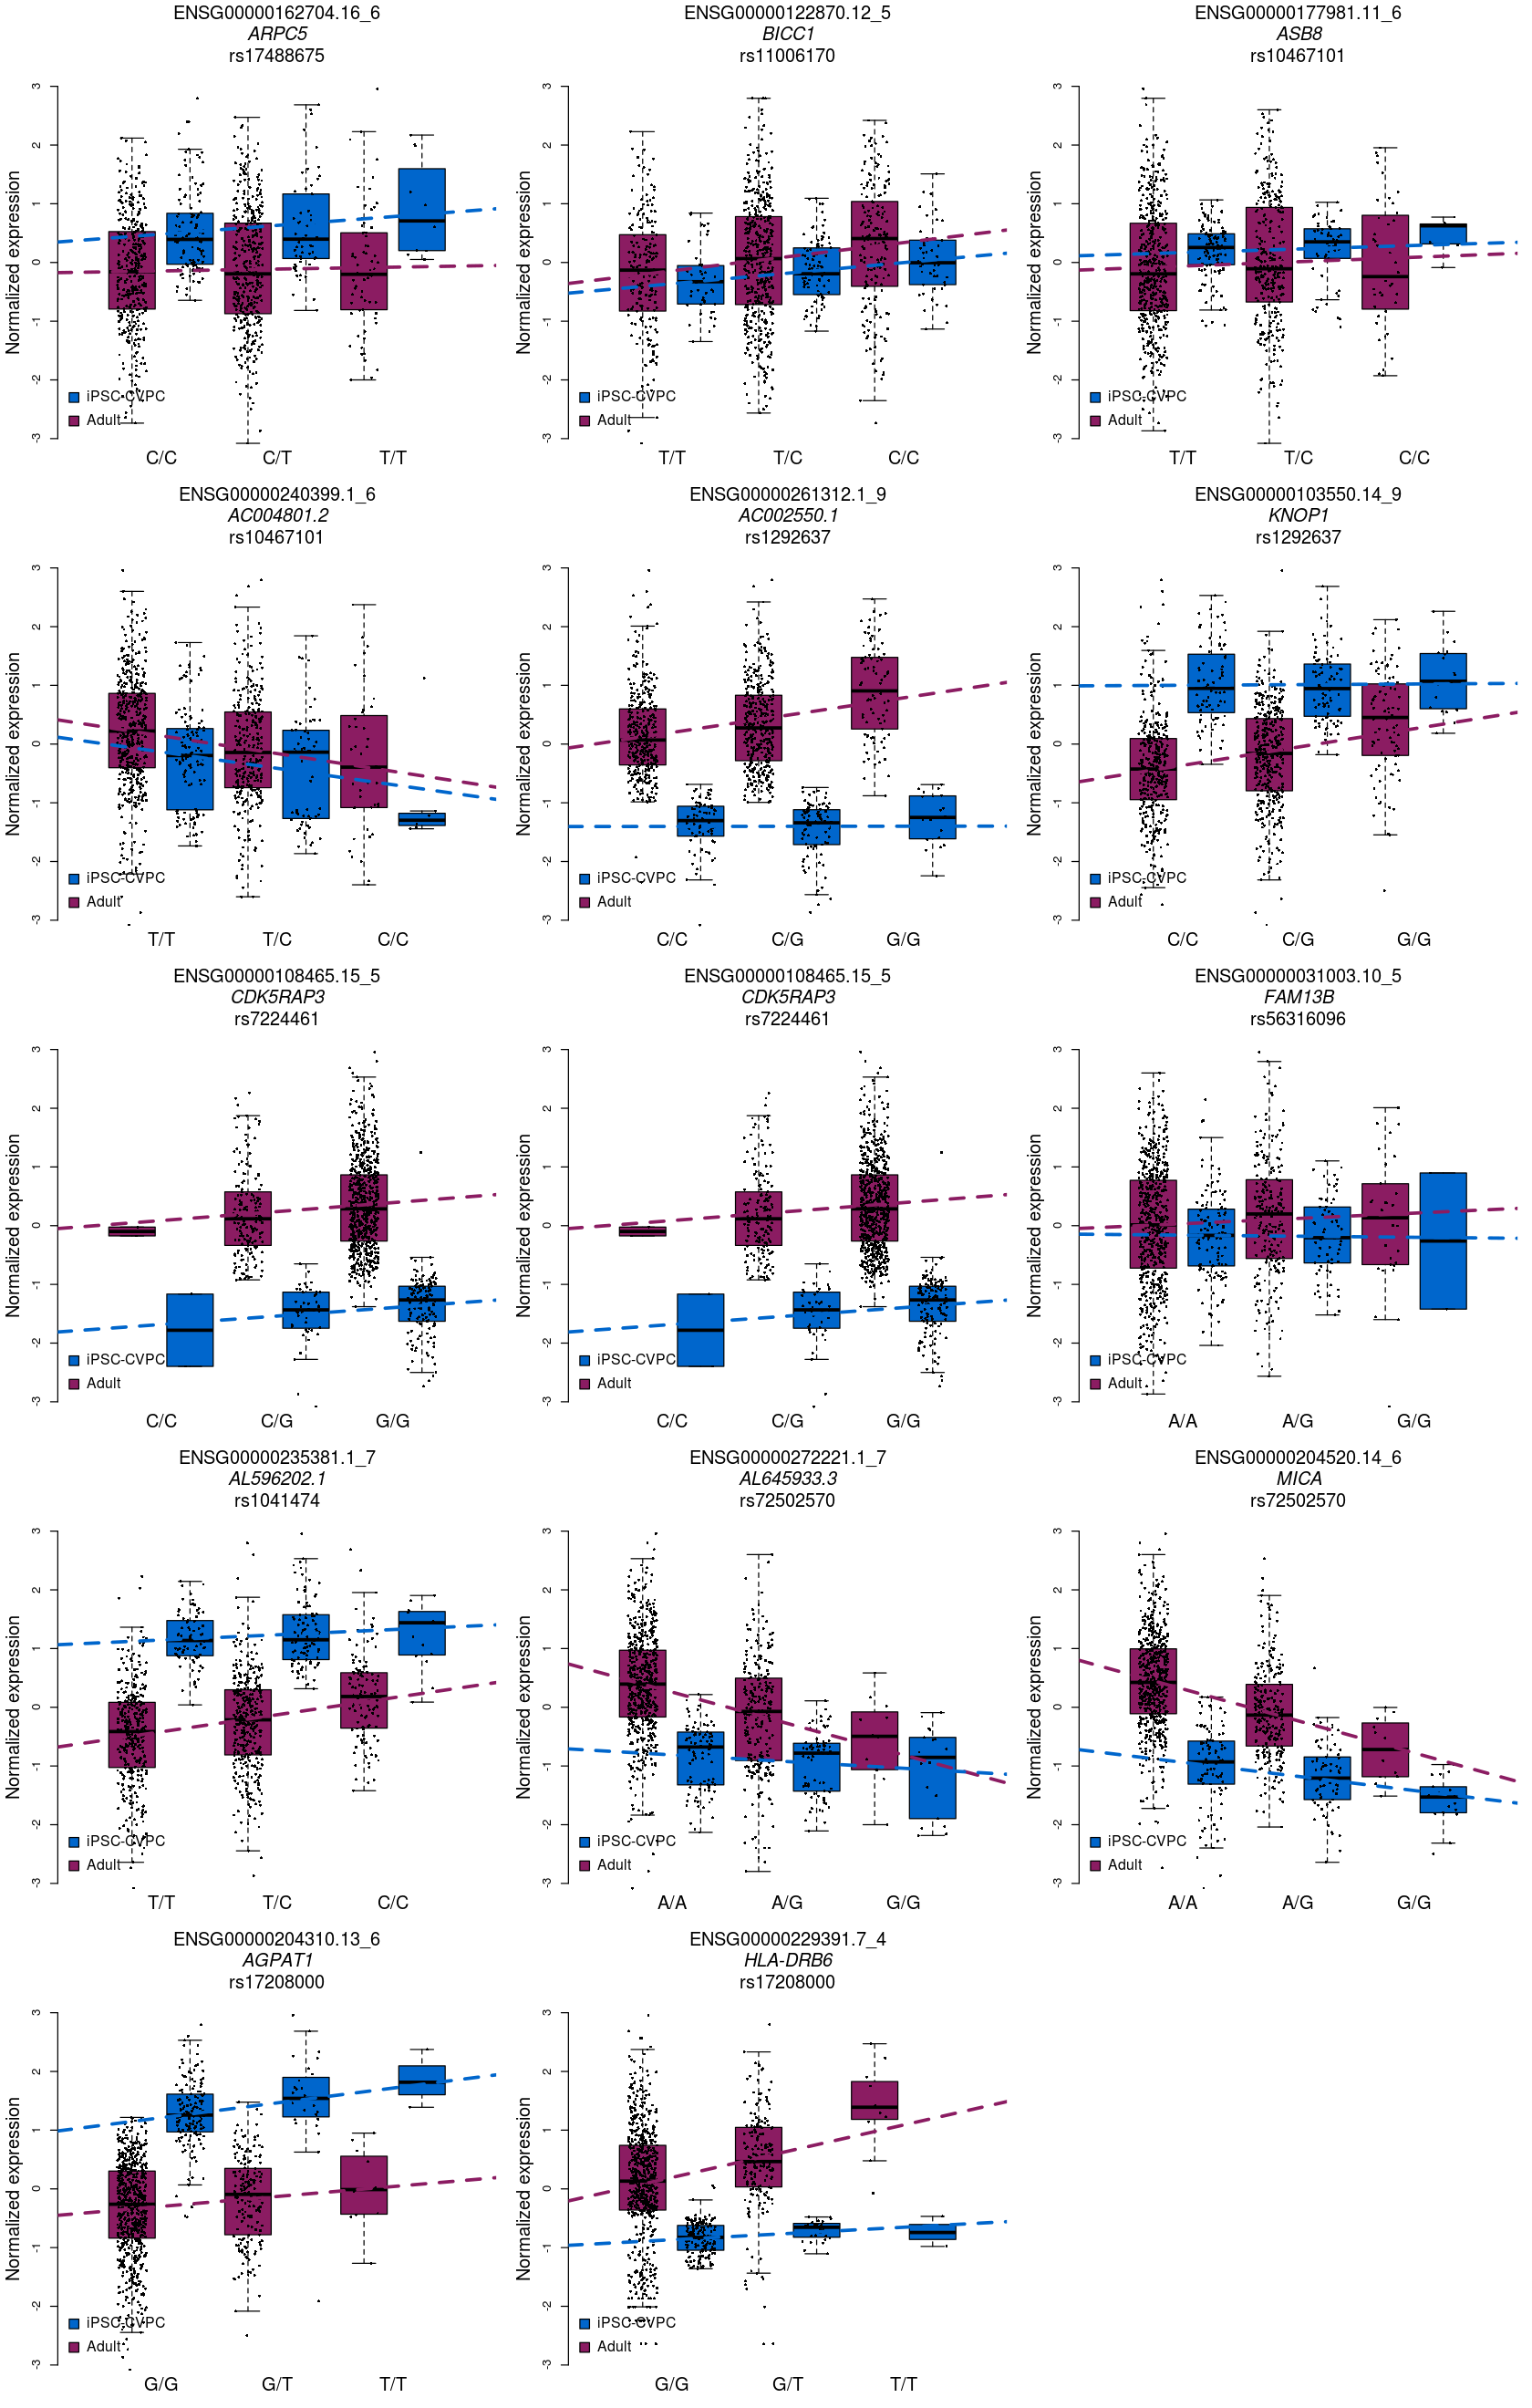

In [63]:
plot_celltype_binary = function(transcript_id, source, id, cell, colordata, legend = FALSE, panel = "")
{
    if(source == "tpm_gene"   ){phenotype = "rna"}
    if(source == "use_isoform"){phenotype = "isoform"}
    
    gtdata      = add_rownames(fread(paste("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/1.3.genotype"  , source, paste("gt_data", transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE))
    gtinfo      =              fread(paste("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/1.3.genotype"  , source, paste("gt_info", transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE)
    gtdata      = data.frame(wgs_id = colnames(gtdata), gt = as.numeric(gtdata[id,]))
    expdata     = exp_data[["expression"]][[phenotype]][["normalized"]][transcript_id,]
    expdata     = data.frame(run = colnames(expdata), norm = as.numeric(expdata[1,]))
    toplot      = merge(exp_data$covariates, exp_data$metadata[,c("run", "wgs_id", "phenotype")], by = "run")
    toplot      = toplot[toplot$phenotype == "rna",]
    toplot      = merge(toplot, expdata, by = "run")
    toplot      = merge(toplot, gtdata , by = "wgs_id"   )
    gtinfo      = gtinfo[gtinfo$id == id,]
    eqtls       = qtl_data[["qtl"]][[phenotype]]
    toplot$cell = toplot[,cell]
    toplot$x    = (toplot$gt * 4 + 1) + toplot$cell
    
    par(mar = c(2,4,5,1))
    #plot(1,1, type = "n", xlim = c(0,7), ylim = range(toplot$norm), axes = FALSE, xlab = "", ylab = "")
    plot(1,1, type = "n", xlim = c(0,7), ylim = c(-3,3), axes = FALSE, xlab = "", ylab = "")
    axis(2)
    
    mycolors = c("#8B1C62", colordata[cell, "color"])
    
    boxplot(norm ~ cell + gt, data = toplot, outline = FALSE, col = rep(mycolors, 3), add = TRUE, at = (1:6), axes = FALSE)
    points (x = jitter(toplot$x, amount = 0.25), y = toplot$norm, pch = 16, cex = 0.5)
    abline (lm(norm ~ x, data = toplot[toplot$cell == 0,]), lty = "dashed", col = mycolors[[1]], lwd = 3)
    abline (lm(norm ~ x, data = toplot[toplot$cell == 1,]), lty = "dashed", col = mycolors[[2]], lwd = 3)
    
    gt1  = gtinfo[1, "ref" ]
    gt2  = gtinfo[1, "alt" ]
    rsid = gtinfo[1, "rsid"]
    gene = exp_data[["coordinates"]]
    gene = gene[ gene$transcript_id == transcript_id & gene$phenotype == "rna", "gene_name"]
    gts  = c(paste(gt1, gt1, sep = "/"), paste(gt1, gt2, sep = "/"), paste(gt2, gt2, sep = "/"))
    
    if(source == "use_isoform"){gene = paste0(transcript_id, " (", gene, ")")}
    
    mtext(gts                    , side = 1, line =  0  , at = c(1.5, 3.5, 5.5))
    mtext(gene                   , side = 3, line =  2  , font = 3)
    mtext(transcript_id          , side = 3, line =  3.5)
    mtext(rsid                   , side = 3, line =  0.5)
    mtext("Normalized expression", side = 2, line =  2.5)
    #mtext(text = panel           , side = 2, line =  2.5, las = 2, at = max(toplot$norm) * 1.05, font = 2, cex = 1.5)
    mtext(text = panel           , side = 2, line =  2.5, las = 2, at = 3 * 1.05, font = 2, cex = 1.5)
    
    if(legend == TRUE)
    {
        mylabs = c("All other samples", colordata[cell, "tissue"])
        
        if (cell == "ipsc_cvpc"      ){mylabs[[1]] = "Adult"         }
        if (cell == "heart_ventricle"){mylabs[[2]] = "Left ventricle"}
        
        myoffset = 0
        #if(eqtls[eqtls$transcript_id == transcript_id & eqtls$id == id, "beta"] > 0){myoffset = 5}
        points(x = rep(0  , 2), y = c(-2.7, -2.3) + myoffset, pch = 22, bg = mycolors, cex = 2)
        text  (x = rep(0.1, 2), y = c(-2.7, -2.3) + myoffset, labels = mylabs, pos = 4, cex = 1.2)
    }
}


options(repr.plot.width = 14, repr.plot.height = 22)
    
layout(matrix(1:15, nrow = 5, byrow = TRUE))

ii = 1

invisible(lapply(1:nrow(totest), function(ii){plot_celltype_binary (totest[ii, "transcript_id"], "tpm_gene", totest[ii, "id"] , "ipsc_cvpc", add_rownames(exp_data$color$by_tissue), TRUE, "")}))



In [69]:
qtl = qtl_data$qtl$rna
qtl[ qtl$transcript_id == "ENSG00000272221.1_7", c("id", "rsid", "type", "beta", "se", "pval", "qval")]

,id,rsid,type,beta,se,pval,qval
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
31711,VAR_6_31327170_G_A,rs3997996,4,0.3663731,0.06858415,4.225748e-08,5.972293e-04
31720,VAR_6_31341490_TG_T,6_31341490_TG_T_b37,3,-1.0328097,0.13339835,6.730637e-16,1.312633e-10
31723,VAR_6_31352972_A_C,6_31352972_A_C_b37,5,-0.9445130,0.18405387,1.005599e-07,1.288984e-03
31724,VAR_6_31355318_T_C,rs2596560,1,-0.7627566,0.09038910,2.358073e-14,9.660526e-10
31725,VAR_6_31361897_A_C,rs2523473,0,-1.6458195,0.11365756,3.847730e-57,3.359282e-52
31730,VAR_6_31375117_T_G,6_31375117_T_G_b37,2,-0.7677160,0.10968906,3.578410e-13,3.710388e-08
